# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

In [2]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (8,5),
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    'font.family': 'serif',
    'legend.fontsize':12,
    'axes.labelsize':18
})

# Importing Kuramoto dataset

We first import the solution obtained from the Kuramoto differential equation subject to periodic boundary conditions. The spatial domain has length L=200 and discretized with 256 nodes. The time step was 0.25 s with a time domain from t=0 to t=2000 s.

\begin{equation}
u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{3}
\end{equation}

\begin{equation}
u(t=0,x) = cos \frac{\pi x}{20}*(1+sin\frac{\pi x}{20})
\end{equation}

The first 100 seconds were truncated in order to view the more chaotic part of the solution

In [5]:
X = np.load('Kuramoto_dataset\Kuramoto_X.npy')
T = np.load('Kuramoto_dataset\Kuramoto_T.npy')
U = np.load('Kuramoto_dataset\Kuramoto_U.npy')

In [6]:
X.shape

(40001, 256)

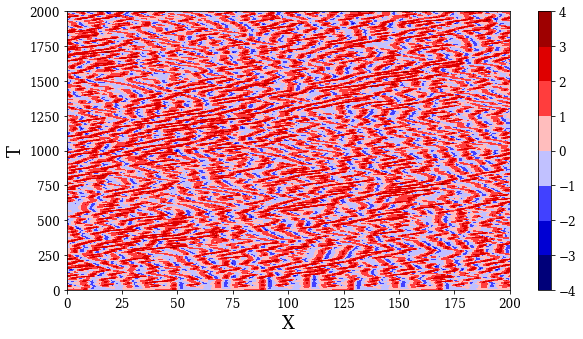

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))

surf = ax.contourf(X, T, U, 15, cmap=plt.get_cmap("seismic"))

plt.colorbar()
plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()

In [8]:
# Taking out the first 100 seconds of data to avoid any transients

X = X[2000:]
T = T[2000:]
U = U[2000:]

## Creating the training and test set for evaluating PCA

In [9]:
# 75% training and 25% testing

X_train = X[:30000]
T_train = T[:30000]
U_train = U[:30000]

X_test = X[30000:]
T_test = T[30000:]
U_test = U[30000:]

In [10]:
print(U_train.shape)
print(U_test.shape)

(30000, 256)
(8001, 256)


In [11]:
# Normalizing the dataset to be with 0 mean and unit variance

scaler = StandardScaler()

U_scaled_train = scaler.fit_transform(U_train)
U_scaled_test = scaler.transform(U_test)

# Applying dimensionality reduction for the Kuramoto dataset

## Principal component analysis (PCA)

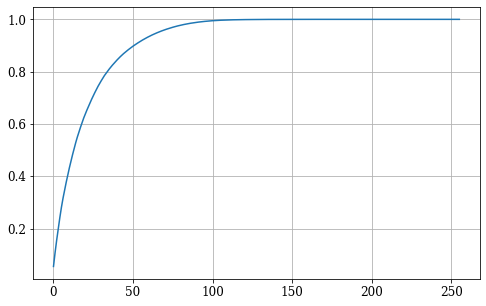

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(U_scaled_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) # Cumulative sum of the variance explained by each dimension 

plt.plot(cumsum)
plt.grid()

In [13]:
d = np.argmax(cumsum >= 0.99) + 1
print(str(d) + ' components')
pca = PCA(n_components=d) # Reduce number of components from 256 to 93
U_train_pca = pca.fit_transform(U_scaled_train)
U_test_pca = pca.transform(U_scaled_test)

93 components


It turns out that I need 93 components for 99% explained variance. We reduced 256 columns to a representation with 93 eigenvectors with associated eigenvalues

In [14]:
U_train_reduced = pca.inverse_transform(U_train_pca)
U_test_reduced = pca.inverse_transform(U_test_pca)
print(U_train_reduced.shape)

U_train_reduced_inverse = scaler.inverse_transform(U_train_reduced)  # Apply inverse transform to obtain dataset in same scale as the original data
U_test_reduced_inverse = scaler.inverse_transform(U_test_reduced)

(30000, 256)


0.10177029744221575


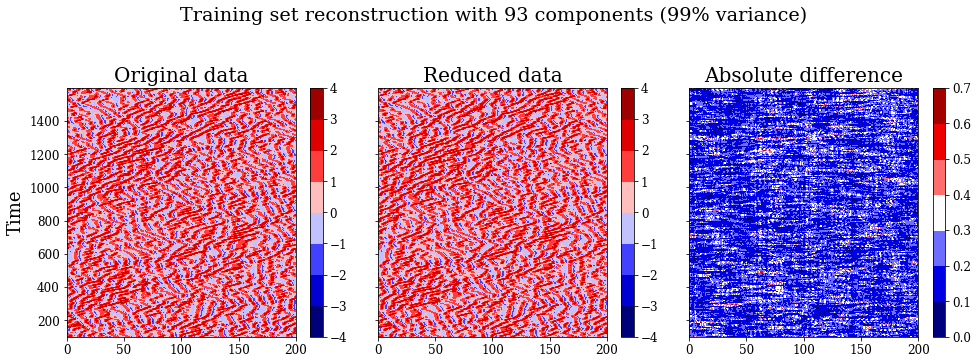

In [15]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(14, 5))
plt.suptitle('Training set reconstruction with 93 components (99% variance)', y=1.02)

surf1 = ax[0].contourf(X_train, T_train, U_train, cmap=plt.get_cmap("seismic"))
fig.colorbar(surf1, ax=ax[0], ticks=None)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].contourf(X_train, T_train, U_train_reduced_inverse,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf2, ax=ax[1])
ax[1].set_title('Reduced data')

surf3 = ax[2].contourf(X_train, T_train, abs(U_train-U_train_reduced_inverse),cmap=plt.get_cmap("seismic")) # 
fig.colorbar(surf3, ax=ax[2])
ax[2].set_title('Absolute difference')

plt.tight_layout()

print(abs(U_train-U_train_reduced_inverse).mean())

0.18097933714679135


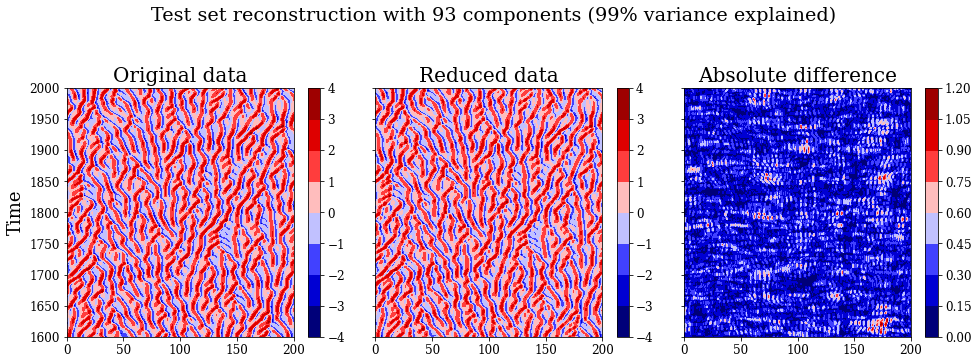

In [16]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(14, 5))
plt.suptitle('Test set reconstruction with 93 components (99% variance explained)', y=1.02)

surf1 = ax[0].contourf(X_test, T_test,U_test, cmap=plt.get_cmap("seismic"))
fig.colorbar(surf1, ax=ax[0], ticks=None)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].contourf(X_test, T_test, U_test_reduced_inverse,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf2, ax=ax[1])
ax[1].set_title('Reduced data')

surf3 = ax[2].contourf(X_test, T_test, abs(U_test-U_test_reduced_inverse),cmap=plt.get_cmap("seismic"))
fig.colorbar(surf3, ax=ax[2])
ax[2].set_title('Absolute difference')

plt.tight_layout()

print(abs(U_test-U_test_reduced_inverse).mean())

Using Standardcaler: 

Training set error: 0.1018 

Test ser error: 0.1809

From the above plot, we consider the precision to be sufficient for this application.

## Final ROM from Kuramoto equation

In [17]:
scaler = StandardScaler()
U_scaled = scaler.fit_transform(U)

pca = PCA(n_components=d)
U_pca = pca.fit_transform(U_scaled)
U_pca.shape

(38001, 93)

In [18]:
df = pd.DataFrame(U_pca)
df

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,2.454402,-3.234479,-3.434734,1.071602,-3.731644,-2.036317,1.955606,2.204623,3.945924,2.671338,...,0.615661,0.829077,0.067804,0.050255,-0.771229,-0.484655,0.361783,-1.249191,0.142736,-0.641381
1,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,...,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167
2,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,...,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654
3,2.349033,-3.141195,-3.406680,1.066396,-3.631030,-1.949915,2.061413,2.271704,3.866951,2.670070,...,0.666789,0.783691,0.053649,0.113663,-0.774070,-0.505771,0.345432,-1.254462,0.105514,-0.639846
4,2.313060,-3.109649,-3.398004,1.064995,-3.596712,-1.920886,2.095544,2.294262,3.840317,2.670425,...,0.683839,0.767593,0.048451,0.134920,-0.775232,-0.512488,0.339811,-1.255345,0.093746,-0.638750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37996,2.379745,-0.453259,-0.905194,1.463400,-4.230125,-0.513917,6.115111,4.323382,1.136034,0.185126,...,0.029323,1.295977,-0.464951,-0.695115,0.500279,-0.119664,0.075665,1.446325,0.233912,0.646551
37997,2.324912,-0.428973,-0.911062,1.475039,-4.251181,-0.579291,6.131503,4.331886,1.147954,0.265081,...,0.020078,1.293034,-0.465476,-0.700141,0.487832,-0.132208,0.092497,1.463184,0.222135,0.649034
37998,2.270125,-0.404139,-0.917700,1.487114,-4.272127,-0.643974,6.148584,4.339339,1.159419,0.342730,...,0.011249,1.290268,-0.465475,-0.705357,0.475070,-0.145397,0.109947,1.479293,0.210241,0.651155
37999,2.215430,-0.378812,-0.925120,1.499621,-4.292953,-0.707869,6.166322,4.345713,1.170436,0.417935,...,0.002826,1.287674,-0.464957,-0.710771,0.462019,-0.159175,0.127973,1.494602,0.198285,0.652934


# Plotting a sample of all time series

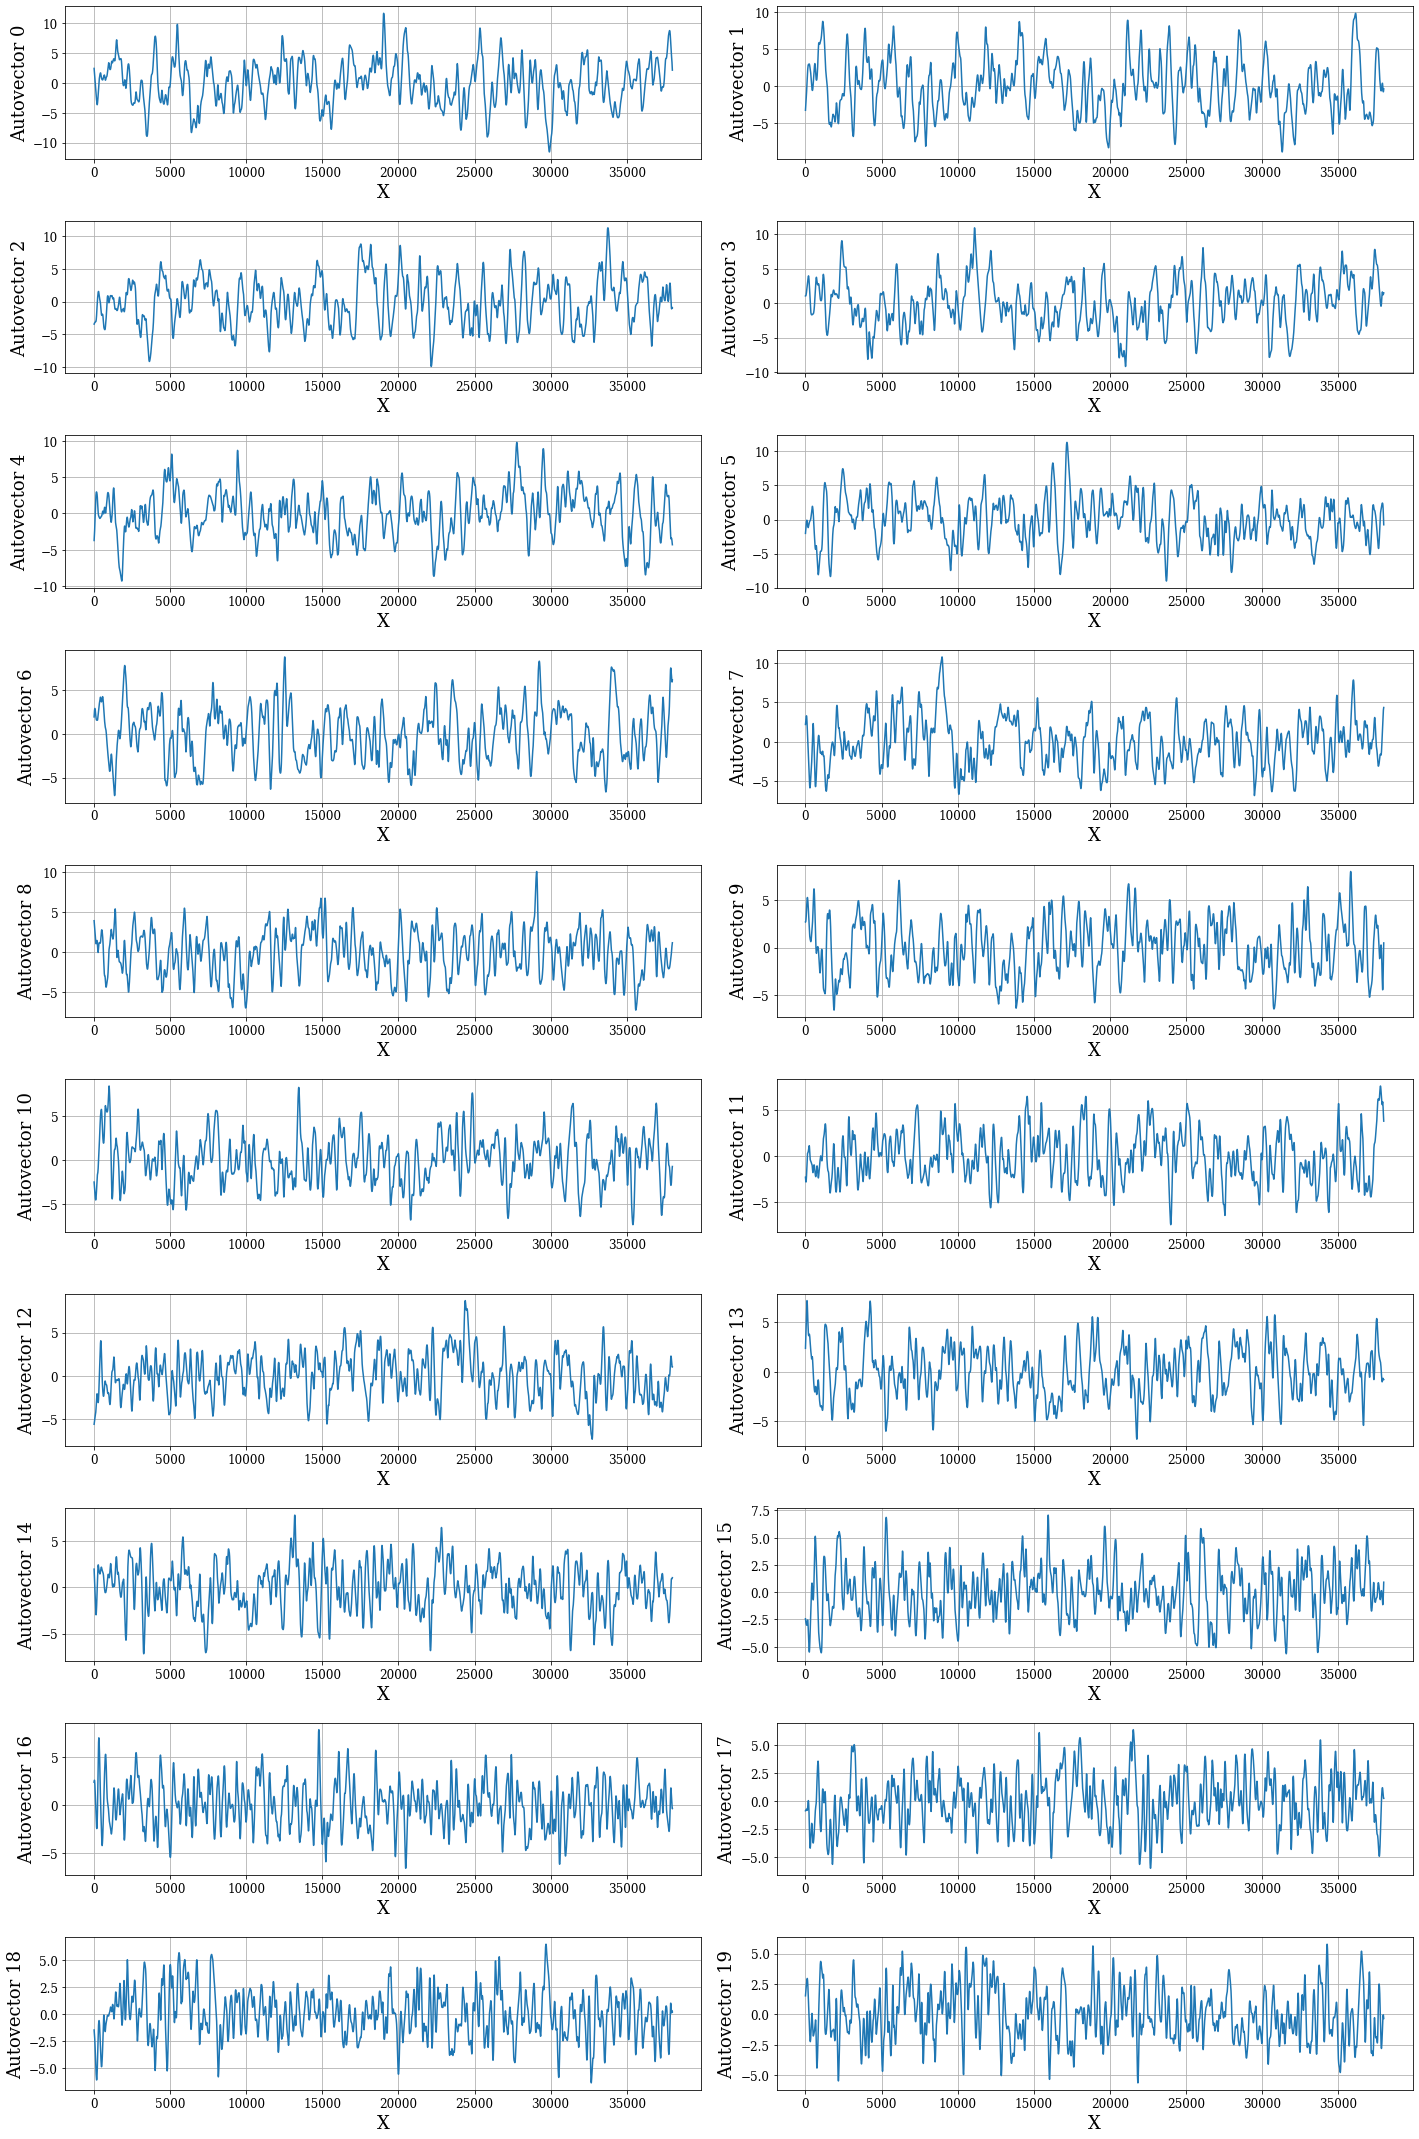

In [19]:
plt.rcParams.update({'figure.figsize': (20, 30)})

for i in range(20):
    plt.subplot(10, 2, i+1)
    plt.plot(df[df.columns[i]], label = df.columns[i])
    
    plt.xlabel('X')
    plt.ylabel('Autovector ' + str(df.columns[i]))
    plt.tight_layout()
    plt.grid()

The time series seem to be random values around 0. Is there some pattern in this data? If so, the selection of forecasting model would be easier

## Dickey-Fuller Test - visualize stationarity

This is the statistical test that we run to determine if a time series is stationary or not. Without going into the technicalities of the Dickey-Fuller test, it tests the null hypothesis that a unit root is present.

- If it is, then p > 0, and the process is not stationary.
- Otherwise, p = 0, the null hypothesis is rejected, and the process is considered to be stationary.

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [1]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [2]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [22]:
for i in range(10):
    print('Autovector ' + str(i))
    sTest = StationarityTests()
    sTest.ADF_Stationarity_Test(timeseries=df[df.columns[i]], printResults = True)
    print("Is the time series stationary? {0}".format(sTest.isStationary))
    print('')

Autovector 0
Augmented Dickey-Fuller Test Results:
ADF Test Statistic         -1.548174
P-Value                     0.509560
# Lags Used                 8.000000
# Observations Used     37992.000000
Critical Value (1%)        -3.430522
Critical Value (5%)        -2.861616
Critical Value (10%)       -2.566810
dtype: float64
Is the time series stationary? False

Autovector 1
Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -29.322179
P-Value                     0.000000
# Lags Used                 7.000000
# Observations Used     37993.000000
Critical Value (1%)        -3.430522
Critical Value (5%)        -2.861616
Critical Value (10%)       -2.566810
dtype: float64
Is the time series stationary? True

Autovector 2
Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -30.997292
P-Value                     0.000000
# Lags Used                 7.000000
# Observations Used     37993.000000
Critical Value (1%)        -3.430522
Critical Value (5%)        -2.861616
Cr

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

for i in range(10):
    ADF_test(timeseries=df[df.columns[i]], 'Autovector ' + str(i))

It seems we have a mixture of stationary and non stationary time series. This leads me to believe that it is likely that we will need more robust models to deal with the non stationarity 

# Creating the dataset for typical ML models

We want to predict the time series one time step in the future. Therefore, we will have a training set at time t and a test set at t+1.

In [23]:
from tqdm import tqdm

y2 = df
X2 = df.shift(1) # atraso o dado com o valor de K

for K in tqdm(range(len(y2))):
    y2 = y2.rename(columns={K: 'Lag ' + str(K)}) # Renaming y columns to differ from X columns
    X2 = X2.rename(columns={K: 'Autovector ' + str(K)}) # Renaming y columns to differ from X columns

100%|████████████████████████████████████████████████████████████████████████████| 38001/38001 [53:10<00:00, 11.91it/s]


In [24]:
X2

,Autovector 0,Autovector 1,Autovector 2,Autovector 3,Autovector 4,Autovector 5,Autovector 6,Autovector 7,Autovector 8,Autovector 9,...,Autovector 83,Autovector 84,Autovector 85,Autovector 86,Autovector 87,Autovector 88,Autovector 89,Autovector 90,Autovector 91,Autovector 92
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.454402,-3.234479,-3.434734,1.071602,-3.731644,-2.036317,1.955606,2.204623,3.945924,2.671338,...,0.615661,0.829077,0.067804,0.050255,-0.771229,-0.484655,0.361783,-1.249191,0.142736,-0.641381
2,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,...,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167
3,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,...,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654
4,2.349033,-3.141195,-3.406680,1.066396,-3.631030,-1.949915,2.061413,2.271704,3.866951,2.670070,...,0.666789,0.783691,0.053649,0.113663,-0.774070,-0.505771,0.345432,-1.254462,0.105514,-0.639846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37996,2.434576,-0.476940,-0.900083,1.452196,-4.208974,-0.447952,6.099434,4.313858,1.123654,0.103008,...,0.038992,1.299100,-0.463896,-0.690268,0.512387,-0.107818,0.059484,1.428768,0.245521,0.643687
37997,2.379745,-0.453259,-0.905194,1.463400,-4.230125,-0.513917,6.115111,4.323382,1.136034,0.185126,...,0.029323,1.295977,-0.464951,-0.695115,0.500279,-0.119664,0.075665,1.446325,0.233912,0.646551
37998,2.324912,-0.428973,-0.911062,1.475039,-4.251181,-0.579291,6.131503,4.331886,1.147954,0.265081,...,0.020078,1.293034,-0.465476,-0.700141,0.487832,-0.132208,0.092497,1.463184,0.222135,0.649034
37999,2.270125,-0.404139,-0.917700,1.487114,-4.272127,-0.643974,6.148584,4.339339,1.159419,0.342730,...,0.011249,1.290268,-0.465475,-0.705357,0.475070,-0.145397,0.109947,1.479293,0.210241,0.651155


In [25]:
y2

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 83,Lag 84,Lag 85,Lag 86,Lag 87,Lag 88,Lag 89,Lag 90,Lag 91,Lag 92
0,2.454402,-3.234479,-3.434734,1.071602,-3.731644,-2.036317,1.955606,2.204623,3.945924,2.671338,...,0.615661,0.829077,0.067804,0.050255,-0.771229,-0.484655,0.361783,-1.249191,0.142736,-0.641381
1,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,...,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167
2,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,...,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654
3,2.349033,-3.141195,-3.406680,1.066396,-3.631030,-1.949915,2.061413,2.271704,3.866951,2.670070,...,0.666789,0.783691,0.053649,0.113663,-0.774070,-0.505771,0.345432,-1.254462,0.105514,-0.639846
4,2.313060,-3.109649,-3.398004,1.064995,-3.596712,-1.920886,2.095544,2.294262,3.840317,2.670425,...,0.683839,0.767593,0.048451,0.134920,-0.775232,-0.512488,0.339811,-1.255345,0.093746,-0.638750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37996,2.379745,-0.453259,-0.905194,1.463400,-4.230125,-0.513917,6.115111,4.323382,1.136034,0.185126,...,0.029323,1.295977,-0.464951,-0.695115,0.500279,-0.119664,0.075665,1.446325,0.233912,0.646551
37997,2.324912,-0.428973,-0.911062,1.475039,-4.251181,-0.579291,6.131503,4.331886,1.147954,0.265081,...,0.020078,1.293034,-0.465476,-0.700141,0.487832,-0.132208,0.092497,1.463184,0.222135,0.649034
37998,2.270125,-0.404139,-0.917700,1.487114,-4.272127,-0.643974,6.148584,4.339339,1.159419,0.342730,...,0.011249,1.290268,-0.465475,-0.705357,0.475070,-0.145397,0.109947,1.479293,0.210241,0.651155
37999,2.215430,-0.378812,-0.925120,1.499621,-4.292953,-0.707869,6.166322,4.345713,1.170436,0.417935,...,0.002826,1.287674,-0.464957,-0.710771,0.462019,-0.159175,0.127973,1.494602,0.198285,0.652934


In [26]:
# Due to the time shift, a line of NaN appeared in the place where there will be no number. The first line of both dataframes X and y must be removed

X2 = X2.drop(0,axis=0)
y2 = y2.drop(0,axis=0) 

In [27]:
X2.head()

,Autovector 0,Autovector 1,Autovector 2,Autovector 3,Autovector 4,Autovector 5,Autovector 6,Autovector 7,Autovector 8,Autovector 9,...,Autovector 83,Autovector 84,Autovector 85,Autovector 86,Autovector 87,Autovector 88,Autovector 89,Autovector 90,Autovector 91,Autovector 92
1,2.454402,-3.234479,-3.434734,1.071602,-3.731644,-2.036317,1.955606,2.204623,3.945924,2.671338,...,0.615661,0.829077,0.067804,0.050255,-0.771229,-0.484655,0.361783,-1.249191,0.142736,-0.641381
2,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,...,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167
3,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,...,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654
4,2.349033,-3.141195,-3.406680,1.066396,-3.631030,-1.949915,2.061413,2.271704,3.866951,2.670070,...,0.666789,0.783691,0.053649,0.113663,-0.774070,-0.505771,0.345432,-1.254462,0.105514,-0.639846
5,2.313060,-3.109649,-3.398004,1.064995,-3.596712,-1.920886,2.095544,2.294262,3.840317,2.670425,...,0.683839,0.767593,0.048451,0.134920,-0.775232,-0.512488,0.339811,-1.255345,0.093746,-0.638750


In [28]:
y2.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 83,Lag 84,Lag 85,Lag 86,Lag 87,Lag 88,Lag 89,Lag 90,Lag 91,Lag 92
1,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,...,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167
2,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,...,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654
3,2.349033,-3.141195,-3.406680,1.066396,-3.631030,-1.949915,2.061413,2.271704,3.866951,2.670070,...,0.666789,0.783691,0.053649,0.113663,-0.774070,-0.505771,0.345432,-1.254462,0.105514,-0.639846
4,2.313060,-3.109649,-3.398004,1.064995,-3.596712,-1.920886,2.095544,2.294262,3.840317,2.670425,...,0.683839,0.767593,0.048451,0.134920,-0.775232,-0.512488,0.339811,-1.255345,0.093746,-0.638750
5,2.276692,-3.077884,-3.389660,1.063786,-3.561999,-1.891760,2.129087,2.316896,3.813543,2.671196,...,0.700894,0.751009,0.043037,0.156211,-0.776465,-0.519045,0.334120,-1.255773,0.082322,-0.637372


# Training traditional ML algorithms

PyCaret Regression Module is a supervised machine learning module used for estimating the relationships between a dependent variable (often called the ‘outcome variable’, or ‘target’) and one or more independent variables (often called ‘features’, or ‘predictors’).

In [29]:
from pycaret.regression import *

## Test 1 

In [30]:
df = pd.concat([X2,y2['Lag 6']],axis=1)
df

,Autovector 0,Autovector 1,Autovector 2,Autovector 3,Autovector 4,Autovector 5,Autovector 6,Autovector 7,Autovector 8,Autovector 9,Autovector 10,Autovector 11,Autovector 12,Autovector 13,Autovector 14,Autovector 15,Autovector 16,Autovector 17,Autovector 18,Autovector 19,Autovector 20,Autovector 21,Autovector 22,Autovector 23,Autovector 24,Autovector 25,Autovector 26,Autovector 27,Autovector 28,Autovector 29,Autovector 30,Autovector 31,Autovector 32,Autovector 33,Autovector 34,Autovector 35,Autovector 36,Autovector 37,Autovector 38,Autovector 39,Autovector 40,Autovector 41,Autovector 42,Autovector 43,Autovector 44,Autovector 45,Autovector 46,Autovector 47,Autovector 48,Autovector 49,Autovector 50,Autovector 51,Autovector 52,Autovector 53,Autovector 54,Autovector 55,Autovector 56,Autovector 57,Autovector 58,Autovector 59,Autovector 60,Autovector 61,Autovector 62,Autovector 63,Autovector 64,Autovector 65,Autovector 66,Autovector 67,Autovector 68,Autovector 69,Autovector 70,Autovector 71,Autovector 72,Autovector 73,Autovector 74,Autovector 75,Autovector 76,Autovector 77,Autovector 78,Autovector 79,Autovector 80,Autovector 81,Autovector 82,Autovector 83,Autovector 84,Autovector 85,Autovector 86,Autovector 87,Autovector 88,Autovector 89,Autovector 90,Autovector 91,Autovector 92,Lag 6
1,2.454402,-3.234479,-3.434734,1.071602,-3.731644,-2.036317,1.955606,2.204623,3.945924,2.671338,-2.501959,-2.304945,-5.645937,2.358696,1.987263,-2.437271,2.369350,-0.841940,-1.460441,1.528997,-2.601319,1.634506,1.478648,4.291831,1.449760,-2.358821,0.204108,0.576961,-1.301807,-1.114687,0.561628,1.171175,1.155736,-0.947303,5.000996,0.077359,1.739702,-1.163013,-1.445974,-0.594980,-1.727334,-0.485286,0.659866,1.010075,-0.273109,-1.247109,-0.878823,-1.280149,-1.014882,-1.369463,-0.068743,-0.294804,-0.474525,0.453513,1.014805,0.321248,-1.493327,-1.205827,-0.778574,-1.955681,0.478903,0.459699,1.524586,-1.008011,0.404801,0.381060,0.079253,0.915493,0.688888,1.362982,0.242884,-0.727551,0.831668,0.843244,-0.654037,0.959076,-0.637364,0.837345,-0.346006,1.193178,-1.212135,0.184484,1.441629,0.615661,0.829077,0.067804,0.050255,-0.771229,-0.484655,0.361783,-1.249191,0.142736,-0.641381,1.991434
2,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,-2.521021,-2.333859,-5.631256,2.411446,1.942718,-2.453099,2.388206,-0.844122,-1.477097,1.546249,-2.592977,1.624686,1.474944,4.312656,1.448835,-2.370813,0.209311,0.573462,-1.309103,-1.115640,0.569722,1.173628,1.166006,-0.956270,5.005598,0.058962,1.717942,-1.175382,-1.423637,-0.622069,-1.711987,-0.488034,0.650853,1.037017,-0.253262,-1.256365,-0.880798,-1.279221,-1.014511,-1.327347,-0.056645,-0.306474,-0.480076,0.441106,1.020187,0.357152,-1.503487,-1.216508,-0.785653,-1.954580,0.460649,0.463406,1.518284,-0.983698,0.421844,0.372812,0.046713,0.909440,0.698659,1.344483,0.234628,-0.734289,0.838373,0.833620,-0.641853,0.983446,-0.636786,0.834300,-0.344280,1.185609,-1.207695,0.180057,1.428133,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167,2.026707
3,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,-2.540493,-2.362008,-5.616358,2.464359,1.898070,-2.468589,2.406275,-0.845893,-1.493859,1.563495,-2.584193,1.614823,1.471011,4.332957,1.447201,-2.381746,0.214010,0.569948,-1.317256,-1.116773,0.577631,1.175454,1.175877,-0.964775,5.009011,0.040648,1.696944,-1.187937,-1.400546,-0.649435,-1.696492,-0.490586,0.641499,1.063376,-0.234291,-1.265516,-0.882904,-1.278086,-1.013628,-1.285200,-0.044032,-0.317807,-0.485601,0.428114,1.025217,0.392779,-1.513698,-1.227460,-0.793067,-1.953703,0.443069,0.466924,1.511899,-0.959393,0.439107,0.365142,0.014330,0.902969,0.708340,1.325567,0.226024,-0.741300,0.844399,0.823810,-0.629349,1.007639,-0.636026,0.831255,-0.342034,1.177829,-1.203269,0.175322,1.414712,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654,2.061413
4,2.349033,-3.141195,-3.4066

Autovector 'Lag 6' mas arbitrarily selected as an example. Given the dataframe X, predict the future values of the 6th autovector at time t + dt

### Setup the enviroment

In [31]:
clf1 = setup(data = df, 
             target = 'Lag 6', 
             data_split_shuffle = False,
             use_gpu = True,
             fold_strategy = 'timeseries',
             preprocess = False,
             train_size = 0.8, 
             silent=True,
             session_id = 123) # testing for predicting one time series

,Description,Value
0,session_id,123
1,Target,Lag 6
2,Original Data,"(38000, 94)"
3,Missing Values,False
4,Numeric Features,93
5,Categorical Features,0
6,Transformed Train Set,"(30400, 93)"
7,Transformed Test Set,"(7600, 93)"
8,Shuffle Train-Test,False
9,Stratify Train-Test,False


In [32]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


### Training the models 

In [33]:
# Training all models from the above list with the exception of three and get the best 3
top3 = compare_models(sort = 'MAE',
                      exclude=['xgboost','gbr','lar','lightgbm','ada','knn','llar'],
                      n_select = 3) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.0246,0.0010,0.0306,0.9999,0.0133,0.0597,0.0250
rf,Random Forest Regressor,0.0293,0.0076,0.0570,0.9994,0.0144,0.0555,10.9850
dt,Decision Tree Regressor,0.0503,0.0215,0.0991,0.9977,0.0246,0.0828,1.0650
br,Bayesian Ridge,0.0821,0.0272,0.0978,0.9966,0.0389,0.2257,0.1460
lr,Linear Regression,0.0823,0.0275,0.0981,0.9966,0.0390,0.2266,0.0530
ridge,Ridge Regression,0.0869,0.0367,0.1061,0.9954,0.0432,0.3730,0.0190
et,Extra Trees Regressor,0.0916,0.0588,0.1599,0.9933,0.0376,0.1300,5.4440
huber,Huber Regressor,0.1050,0.0624,0.1293,0.9922,0.0520,0.4458,1.5220
par,Passive Aggressive Regressor,0.2276,0.1774,0.2791,0.9781,0.0959,0.7164,0.0670
en,Elastic Net,0.2419,0.0893,0.2931,0.9887,0.0703,0.1385,0.0240


In [34]:
top3

[OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                           normalize=True, precompute='auto', tol=None),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
        

In [35]:
best = top3[0]

In [36]:
prediction_holdout = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.0213,0.0007,0.0270,0.9999,0.0116,0.0366


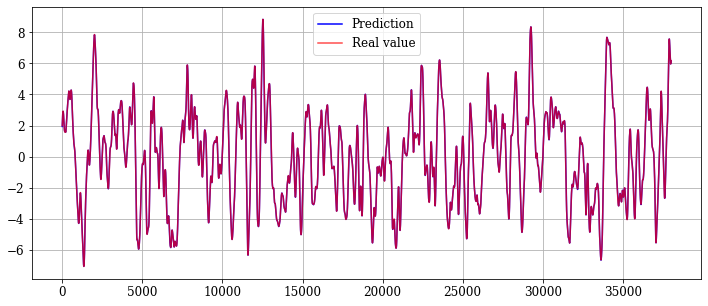

In [37]:
# generate predictions on the original dataset
predictions = predict_model(best, data=df)

plt.figure(figsize=(12,5))
plt.plot(predictions.index,predictions['Label'],color='blue',label='Prediction')
plt.plot(predictions.index,predictions['Lag 6'],color='red',alpha=0.7,label='Real value')
plt.legend()
plt.grid()

In [38]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

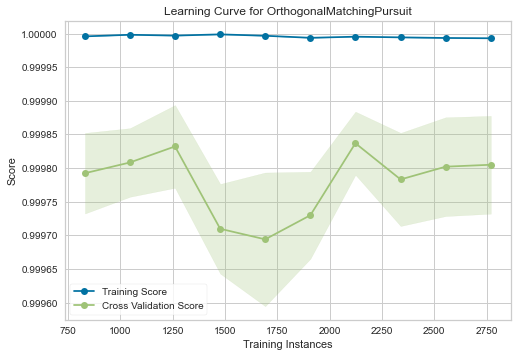

In [39]:
plot_model(estimator = best, plot = 'learning')

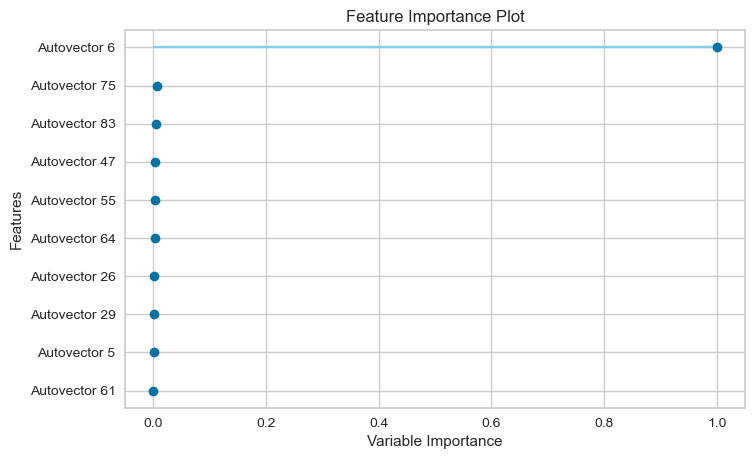

In [40]:
plot_model(estimator = best, plot = 'feature')

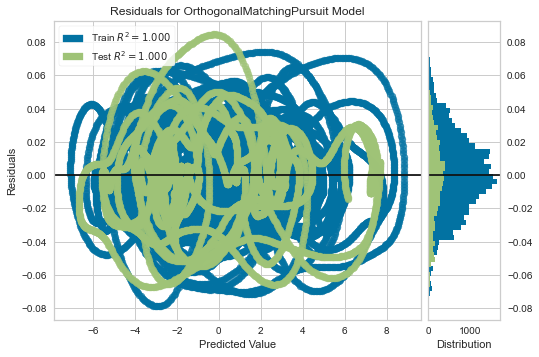

In [41]:
plot_model(estimator = best, plot = 'residuals')

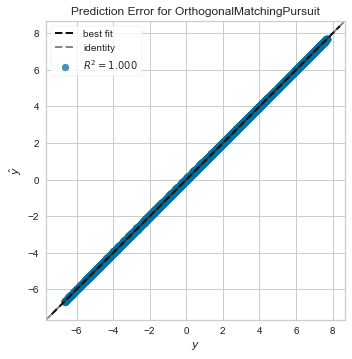

In [42]:
plot_model(estimator = best, plot = 'error')

In [43]:
#tuned_model = tune_model(best, 
#                         n_iter=5, 
#                         optimize='MSE',
#                         fold=3,
#                        #search_library = 'optuna',
#                         early_stopping=True)

#print(tuned_model)

### Model ready for deployment

In [44]:
#final_model = finalize_model(best)
#print(final_model)

## Predicting multiple time series

Let's see if the result of pycaret for different time series will result in different models

In [45]:
#all_results = []
#final_model = {}

#for i in tqdm(range(5)):
    
#    df_new = pd.concat([X,y[y.columns[i]]],axis=1) # create a new dataframe with X and 1 column from y
    
    # initialize setup from pycaret.regression
#    s = setup(df_new, target = y.columns[i], 
#              train_size = 0.70,
#              data_split_shuffle = False, 
#              fold_strategy = 'timeseries', 
#              fold = 5,
#              silent=True,
#              session_id = 123,
#              verbose=False)
    
    # compare all models and select best one based on MAE
#    best_model = compare_models(sort = 'MAE', 
#                                exclude=['xgboost','gbr','lar','lightgbm','ada'],
#                                verbose=False);
    
    # capture the compare result grid and store best model in list
#    p = pull().iloc[0:1]
    #print(p)
#    p['time_series'] = str(i)
    #print(p)
#    all_results.append(p)
    #print(all_results)
    
    # finalize model i.e. fit on entire data including test set
#    f = finalize_model(best_model);
    
    # attach final model to a dictionary
#    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
#    save_model(f, model_name='trained_models/' + str(i), verbose=False)

# Training final model - direct approach

The direct approach to multioutput regression involves dividing the regression problem into a separate problem for each target variable to be predicted.

This assumes that the outputs are independent of each other, which might not be a correct assumption. Nevertheless, this approach can provide surprisingly effective predictions on a range of problems and may be worth trying, at least as a performance baseline.

In [46]:
# 75% training and 25% testing

X_train2 = X2[0:30000]
X_test2 = X2[30000:]

y_train2 = y2[0:30000]
y_test2 = y2[30000:]

T_train2 = T[0:30000]
T_test2 = T[30000:]

D_train2 = T[0:30000]
D_test2 = T[30000:]

In [47]:
X_train2

,Autovector 0,Autovector 1,Autovector 2,Autovector 3,Autovector 4,Autovector 5,Autovector 6,Autovector 7,Autovector 8,Autovector 9,...,Autovector 83,Autovector 84,Autovector 85,Autovector 86,Autovector 87,Autovector 88,Autovector 89,Autovector 90,Autovector 91,Autovector 92
1,2.454402,-3.234479,-3.434734,1.071602,-3.731644,-2.036317,1.955606,2.204623,3.945924,2.671338,...,0.615661,0.829077,0.067804,0.050255,-0.771229,-0.484655,0.361783,-1.249191,0.142736,-0.641381
2,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,...,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167
3,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,...,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654
4,2.349033,-3.141195,-3.406680,1.066396,-3.631030,-1.949915,2.061413,2.271704,3.866951,2.670070,...,0.666789,0.783691,0.053649,0.113663,-0.774070,-0.505771,0.345432,-1.254462,0.105514,-0.639846
5,2.313060,-3.109649,-3.398004,1.064995,-3.596712,-1.920886,2.095544,2.294262,3.840317,2.670425,...,0.683839,0.767593,0.048451,0.134920,-0.775232,-0.512488,0.339811,-1.255345,0.093746,-0.638750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,-10.076042,-0.027404,0.405514,0.371521,-1.856035,4.123544,-0.155862,-3.915660,1.774553,-1.664517,...,0.681092,-0.537946,0.220335,0.018718,-0.215196,0.037298,-0.169067,0.306852,-0.485180,0.034641
29997,-10.048347,0.016472,0.404059,0.364242,-1.890386,4.091794,-0.133287,-3.939111,1.766236,-1.692015,...,0.668083,-0.532224,0.219789,0.006678,-0.212786,0.040478,-0.154962,0.311908,-0.484450,0.041689
29998,-10.020605,0.060535,0.402635,0.356722,-1.924447,4.059510,-0.110561,-3.962142,1.757573,-1.719514,...,0.654438,-0.526201,0.218431,-0.005308,-0.210147,0.043697,-0.141081,0.316632,-0.483946,0.049416
29999,-9.992828,0.104770,0.401243,0.348963,-1.958193,4.026705,-0.087680,-3.984759,1.748565,-1.747012,...,0.640164,-0.519880,0.216259,-0.017219,-0.207307,0.046954,-0.127450,0.321017,-0.483680,0.057830


In [48]:
y_train2

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 83,Lag 84,Lag 85,Lag 86,Lag 87,Lag 88,Lag 89,Lag 90,Lag 91,Lag 92
1,2.419722,-3.203614,-3.425043,1.069716,-3.698492,-2.007641,1.991434,2.226871,3.919764,2.670544,...,0.632702,0.814431,0.063339,0.071316,-0.772047,-0.491854,0.356427,-1.251374,0.130025,-0.641167
2,2.384593,-3.172518,-3.415692,1.067975,-3.664955,-1.978837,2.026707,2.249236,3.893437,2.670116,...,0.649744,0.799303,0.058616,0.092457,-0.773001,-0.498893,0.350974,-1.253135,0.117613,-0.640654
3,2.349033,-3.141195,-3.406680,1.066396,-3.631030,-1.949915,2.061413,2.271704,3.866951,2.670070,...,0.666789,0.783691,0.053649,0.113663,-0.774070,-0.505771,0.345432,-1.254462,0.105514,-0.639846
4,2.313060,-3.109649,-3.398004,1.064995,-3.596712,-1.920886,2.095544,2.294262,3.840317,2.670425,...,0.683839,0.767593,0.048451,0.134920,-0.775232,-0.512488,0.339811,-1.255345,0.093746,-0.638750
5,2.276692,-3.077884,-3.389660,1.063786,-3.561999,-1.891760,2.129087,2.316896,3.813543,2.671196,...,0.700894,0.751009,0.043037,0.156211,-0.776465,-0.519045,0.334120,-1.255773,0.082322,-0.637372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,-10.048347,0.016472,0.404059,0.364242,-1.890386,4.091794,-0.133287,-3.939111,1.766236,-1.692015,...,0.668083,-0.532224,0.219789,0.006678,-0.212786,0.040478,-0.154962,0.311908,-0.484450,0.041689
29997,-10.020605,0.060535,0.402635,0.356722,-1.924447,4.059510,-0.110561,-3.962142,1.757573,-1.719514,...,0.654438,-0.526201,0.218431,-0.005308,-0.210147,0.043697,-0.141081,0.316632,-0.483946,0.049416
29998,-9.992828,0.104770,0.401243,0.348963,-1.958193,4.026705,-0.087680,-3.984759,1.748565,-1.747012,...,0.640164,-0.519880,0.216259,-0.017219,-0.207307,0.046954,-0.127450,0.321017,-0.483680,0.057830
29999,-9.965032,0.149156,0.399887,0.340970,-1.991597,3.993393,-0.064640,-4.006965,1.739213,-1.774508,...,0.625273,-0.513265,0.213274,-0.029030,-0.204294,0.050249,-0.114097,0.325058,-0.483663,0.066933


In [49]:
from sklearn.linear_model import OrthogonalMatchingPursuit # Best model from section 6.1.2
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import RandomForestRegressor

In [50]:
tscv = TimeSeriesSplit(n_splits=5)

In [51]:
omp = OrthogonalMatchingPursuitCV()
#omp = RandomForestRegressor()
wrapper = MultiOutputRegressor(omp)

wrapper.fit(X_train2, y_train2)

MultiOutputRegressor(estimator=OrthogonalMatchingPursuitCV(copy=True, cv=None,
                                                           fit_intercept=True,
                                                           max_iter=None,
                                                           n_jobs=None,
                                                           normalize=True,
                                                           verbose=False),
                     n_jobs=None)

In [52]:
n_scores = cross_val_score(wrapper, X_train2, y_train2, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)
# force the scores to be positive
n_scores = abs(n_scores)
# summarize performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Test dataset performance R^2
wrapper.score(X_test2,y_test2)

MAE: 0.016 (0.000)


0.9997214839777137

In [53]:
# generate predictions on the original dataset
yhat = wrapper.predict(X_test2)

In [54]:
import sys
sys.path.insert(0, 'C:\\Users\\arthu\\Documents\\Mestrado\\Codigos\\Irregularidade')

from model_summary_functions import metrics

In [55]:
metrics(y_test2,yhat)

MSE:0.00046493239359076896 
MAE:0.016295801068827744 
R2:0.9997214839777137


# Visualizing the Kuramoto equation from model prediction

In [56]:
y_test_forecast = pca.inverse_transform(yhat) # Returning the 93 time series back into the problem series 
y_test_forecast.shape

(8000, 256)

In [57]:
# Remove first row from all dataframes to correctly compare results

X_test2 = X_test[0:-1]
T_test2 = T_test[0:-1]
U_test2 = U_test[0:-1]
U_test_reduced2 = U_test_reduced_inverse[0:-1]

In [58]:
X_test[0:-1].shape

(8000, 256)

0.18097933714679135


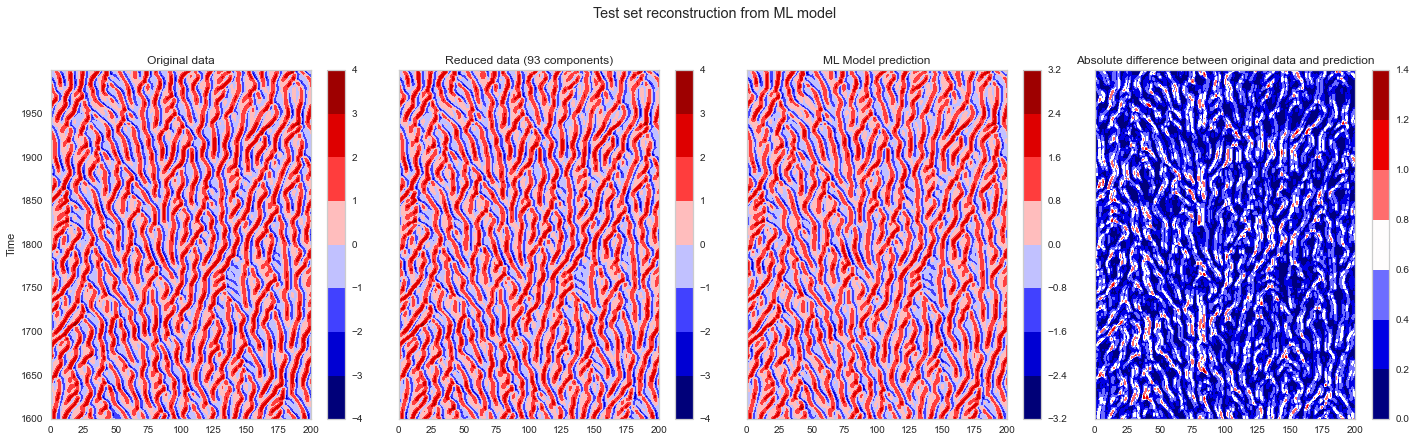

In [60]:
fig, ax = plt.subplots(1,4,sharey=True,figsize=(20, 6))
plt.suptitle('Test set reconstruction from ML model', y=1.02)

surf1 = ax[0].contourf(X_test2, T_test2,U_test2, cmap=plt.get_cmap("seismic"))
fig.colorbar(surf1, ax=ax[0], ticks=None)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].contourf(X_test2, T_test2, U_test_reduced2,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf2, ax=ax[1])
ax[1].set_title('Reduced data (93 components)')

surf3 = ax[2].contourf(X_test[0:-1], T_test[0:-1], y_test_forecast,cmap=plt.get_cmap("seismic"))
fig.colorbar(surf3, ax=ax[2])
ax[2].set_title('ML Model prediction')


surf4 = ax[3].contourf(X_test[0:-1],  T_test[0:-1], abs(U_test2 - y_test_forecast),cmap=plt.get_cmap("seismic"))
fig.colorbar(surf4, ax=ax[3])
ax[3].set_title('Absolute difference between original data and prediction')

plt.tight_layout()

print(abs(U_test-U_test_reduced_inverse).mean())

- Test set error from reduced components (using 93 instead of 256): 0.1809 
- Test set error from model prediction: 0.1810

Comparando visualmente com o erro ao usar 93 autovetores ao inves das 256 colunas originais:
    
    
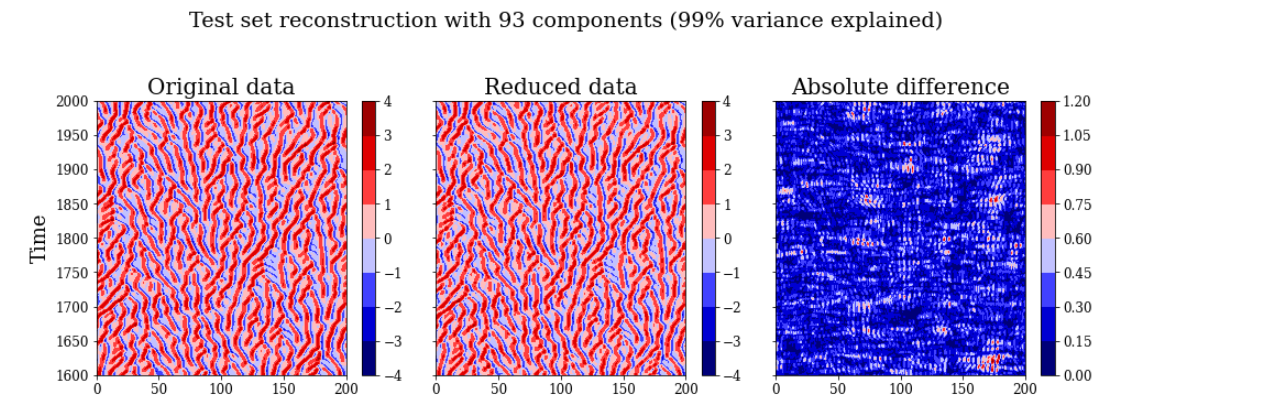


Não foi necessário usar um RNN ou LSTM para conseguir modelar as 93 séries temporais. Não vejo motivo em testar redes neurais visto a precisão do resultado